# Проект для «Викишоп» c BERT (и без BERT)

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve 
from sklearn.metrics import precision_recall_curve

import torch
import transformers
from tqdm import notebook

from pymystem3 import Mystem
import re
import spacy

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.corpus import stopwords as nltk_stopwords

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Константы
RS = 12345 # random state
TS = .25 # test size
FR_DOWNSAMPLE = 0.1 # fraction downsample
FR_DOWNSAMPLE_CLASS = 0.1 # fraction downsample for class
MAX_WORDS = 100 # maximum words in sentences
CRIT_F1 = .75
MXL = 50 # max lenght BERT

In [3]:
df_comm = pd.read_csv('/datasets/toxic_comments.csv')
df_comm.info()
display(df_comm.head())
display(df_comm.query('toxic==1').head()) # А что насчет токсичных комментов?
display(df_comm.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [4]:
df_comm['len'] = df_comm['text'].apply(len)
print('Размер комментариев (в символах):', df_comm['len'].min(),'-',df_comm['len'].max())
df_comm = df_comm.drop('len', axis=1)
cnt = df_comm[df_comm['toxic']==1]['toxic'].count()
all = df_comm.shape[0]
print(f'Количество токсичных комментариев {cnt} из общего числа {all} ({np.round(100 * cnt / all, 2)}%)')

Размер комментариев (в символах): 6 - 5000
Количество токсичных комментариев 16225 из общего числа 159571 (10.17%)


In [5]:
# Надо сбалансировать классы - т.к. мы предсказываем токсичность, то уменьшим количество нетоксичных комментов в выборке

def downsample(df_in, ftr, trg, fraction):
    features_zeros = df_in[df_in[trg] == 0][ftr]
    features_ones = df_in[df_in[trg] == 1][ftr]
    target_zeros = df_in[df_in[trg] == 0][trg]
    target_ones = df_in[df_in[trg] == 1][trg]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=RS)] + [features_ones]) 
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=RS)] + [target_ones]) 
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=RS)
    
    df_out = pd.DataFrame()
    df_out[ftr] = features_downsampled
    df_out[trg] = target_downsampled
    return df_out

In [6]:
# Удаляем нетоксичные комментарии
print('Размер выборки ДО:', df_comm.shape)

df_comm = downsample(df_in=df_comm, ftr='text', trg='toxic', fraction=FR_DOWNSAMPLE_CLASS)

print('Размер выборки ПОСЛЕ:',df_comm.shape)

Размер выборки ДО: (159571, 2)
Размер выборки ПОСЛЕ: (30560, 2)


In [7]:
print(f'Мы удалили {round(FR_DOWNSAMPLE_CLASS*100)}% нетоксичных комментариев. Проверяем что получилось:')
cnt = df_comm[df_comm['toxic']==1]['toxic'].count()
all = df_comm.shape[0]
prc = np.round(100 * cnt / all, 0)
print(f'Количество токсичных комментариев {cnt} из общего числа {all} ({prc}%)')
ppp = int(np.round(prc / 10, 0))
if ppp == 5:
    print('Выборка сбалансирована!')

Мы удалили 10% нетоксичных комментариев. Проверяем что получилось:
Количество токсичных комментариев 16225 из общего числа 30560 (53.0%)
Выборка сбалансирована!


In [8]:
# Сначала потренируемся на малом объеме данных
print(f'Для исследования берем {round(FR_DOWNSAMPLE*100)}% от сбалансированной выборки.')
df_comm = df_comm.sample(frac=FR_DOWNSAMPLE, random_state=RS).reset_index(drop=True)
df_comm.info()

Для исследования берем 10% от сбалансированной выборки.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3056 non-null   object
 1   toxic   3056 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.9+ KB


In [9]:
print('Проверим как изменился % токсичных комментарив после уменьшения выборки:')
cnt = df_comm[df_comm['toxic']==1]['toxic'].count()
all = df_comm.shape[0]
print(f'Количество токсичных комментариев {cnt} из общего числа {all} ({np.round(100 * cnt / all, 2)}%)')
ppp = int(np.round(prc / 10, 0))
if ppp == 5:
    print('Выборка сбалансирована!')

Проверим как изменился % токсичных комментарив после уменьшения выборки:
Количество токсичных комментариев 1624 из общего числа 3056 (53.14%)
Выборка сбалансирована!


### Вариант с BERT

In [10]:
%time

#tokenizer = transformers.BertTokenizer(vocab_file='/datasets/ds_bert/vocab.txt')
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenized = df_comm['text'].apply(lambda x: tokenizer.encode(x, truncation=True, max_length=MXL, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values]) 
attention_mask = np.where(padded != 0, 1, 0)
#config = transformers.BertConfig.from_json_file('/datasets/ds_bert/bert_config.json')
#model = transformers.BertModel.from_pretrained('/datasets/ds_bert/rubert_model.bin', config=config)
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
%time

batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


  0%|          | 0/30 [00:00<?, ?it/s]

In [12]:
%time

bert_features = np.concatenate(embeddings)
l1 = len(bert_features)
print('Размер выборки features:', l1)
bert_target = df_comm['toxic']
l2 = len(bert_target)
print('Размер выборки target:', l2)

if l1 < l2:
    print('Что-то пошло не так - куда-то подевалась часть признаков. Отбрасываем лишние таргеты.')
    bert_target = bert_target[:l1]
    print('Размер выборки target (cut):',len(bert_target))
elif l1 > l2:
    print('Что-то пошло не так - куда-то подевалась часть таргетов. Отбрасываем лишние признаки.')
    bert_features = bert_features[:l2]
    print('Размер выборки features target (cut):',len(bert_features))

print('Разделяем выборку на обучающую и тестовую:')
bert_features_train, bert_features_test, bert_target_train, bert_target_test = train_test_split(bert_features, bert_target, test_size=0.25, random_state=RS)
print('-- размер обучающей выборки:', bert_features_train.shape[0], 'признаков и', len(bert_target_train), 'таргетов')
print('-- размер тестовой выборки:', bert_features_test.shape[0], 'признаков и', len(bert_target_test), 'таргетов')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Размер выборки features: 3000
Размер выборки target: 3056
Что-то пошло не так - куда-то подевалась часть признаков. Отбрасываем лишние таргеты.
Размер выборки target (cut): 3000
Разделяем выборку на обучающую и тестовую:
-- размер обучающей выборки: 2250 признаков и 2250 таргетов
-- размер тестовой выборки: 750 признаков и 750 таргетов


### Вариант без BERT

In [13]:
def lemmatize_m(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
    return lemm_text

ttt = "The striped bats are hanging on their feet for best"
print('Проверяем работу Mystem (с POS):')
print('Исходная фраза:', ttt)
print('Лемматизированная Mystem:', lemmatize_m(ttt))

def clear_text_eng(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text) 
    clear_text = " ".join(clear_text.split())
    return clear_text

Проверяем работу Mystem (с POS):
Исходная фраза: The striped bats are hanging on their feet for best
Лемматизированная Mystem: The striped bats are hanging on their feet for best



### Вывод:
Mystem не подходит для лемматизации английских текстов.

In [14]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [15]:
lemmatizer = WordNetLemmatizer()

def lemmatize_eng_nltk(sentence):
    word_list = nltk.word_tokenize(sentence)
# ограничиваем максимум анализируемых слов в комментарии      
    l = MAX_WORDS
    if len(word_list)<MAX_WORDS:
        l = len(word_list)
    word_list = word_list[:l] 
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
#    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

print('Проверяем работу nltk (с POS):')
print('Исходная фраза:', ttt)
print('Лемматизированная nltk (с POS):', lemmatize_eng_nltk(ttt))

Проверяем работу nltk (с POS):
Исходная фраза: The striped bats are hanging on their feet for best
Лемматизированная nltk (с POS): The strip bat be hang on their foot for best


In [16]:
%time

print('Очищаем комментарии...')
df_comm['clear_text'] = df_comm['text'].apply(clear_text_eng)
display(df_comm.head())
print('Лемматизируем комментарии с nltk...')
df_comm['nltk_text'] = df_comm['clear_text'].apply(lemmatize_eng_nltk)
display(df_comm.head())

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs
Очищаем комментарии...


,text,toxic,clear_text
0,liar \n\nThis guy is such a thief and a liar! ...,1,liar This guy is such a thief and a liar He sh...
1,"""\n\nOf course, of course, Pharos, I am famili...",0,Of course of course Pharos I am familiar with ...
2,My Thoughts \n\nYou're a jackass.\n\nDoes this...,1,My Thoughts You re a jackass Does this look fa...
3,. I should become a detective for figuring all...,1,I should become a detective for figuring all t...
4,GIMME GIMME \n\nI wanted all of you BASTARDS t...,1,GIMME GIMME I wanted all of you BASTARDS to kn...


Лемматизируем комментарии с nltk...


,text,toxic,clear_text,nltk_text
0,liar \n\nThis guy is such a thief and a liar! ...,1,liar This guy is such a thief and a liar He sh...,liar This guy be such a thief and a liar He sh...
1,"""\n\nOf course, of course, Pharos, I am famili...",0,Of course of course Pharos I am familiar with ...,Of course of course Pharos I be familiar with ...
2,My Thoughts \n\nYou're a jackass.\n\nDoes this...,1,My Thoughts You re a jackass Does this look fa...,My Thoughts You re a jackass Does this look fa...
3,. I should become a detective for figuring all...,1,I should become a detective for figuring all t...,I should become a detective for figure all tha...
4,GIMME GIMME \n\nI wanted all of you BASTARDS t...,1,GIMME GIMME I wanted all of you BASTARDS to kn...,GIM ME GIM ME I want all of you BASTARDS to kn...


In [17]:
%time

nlp = spacy.load("en_core_web_sm")

def lemmatize_eng_spacy(sentence):
    doc = nlp(sentence)
# ограничиваем максимум анализируемых слов в комментарии    
    l = MAX_WORDS
    if len(doc)<MAX_WORDS:
        l = len(doc)
    doc = doc[0:l]
    txt = " ".join([token.lemma_ for token in doc])
    return txt

print('Проверяем работу spacy:')
print('Исходная фраза:', ttt)
print('Лемматизированная spacy:', lemmatize_eng_spacy(ttt))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
Проверяем работу spacy:
Исходная фраза: The striped bats are hanging on their feet for best
Лемматизированная spacy: the stripe bat be hang on their foot for good


In [18]:
%time

print('Лемматизируем комментарии со spacy...')
df_comm['spacy_text'] = df_comm['clear_text'].apply(lemmatize_eng_spacy)
display(df_comm.head())

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Лемматизируем комментарии со spacy...


,text,toxic,clear_text,nltk_text,spacy_text
0,liar \n\nThis guy is such a thief and a liar! ...,1,liar This guy is such a thief and a liar He sh...,liar This guy be such a thief and a liar He sh...,liar this guy be such a thief and a liar he sh...
1,"""\n\nOf course, of course, Pharos, I am famili...",0,Of course of course Pharos I am familiar with ...,Of course of course Pharos I be familiar with ...,of course of course Pharos I be familiar with ...
2,My Thoughts \n\nYou're a jackass.\n\nDoes this...,1,My Thoughts You re a jackass Does this look fa...,My Thoughts You re a jackass Does this look fa...,my thought you re a jackass do this look famil...
3,. I should become a detective for figuring all...,1,I should become a detective for figuring all t...,I should become a detective for figure all tha...,I should become a detective for figure all tha...
4,GIMME GIMME \n\nI wanted all of you BASTARDS t...,1,GIMME GIMME I wanted all of you BASTARDS to kn...,GIM ME GIM ME I want all of you BASTARDS to kn...,GIMME GIMME I want all of you bastards to know...


In [19]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

### Cначала детально пройдемся по spacy

In [20]:
# сначала детально пройдемся по spacy
#spacy_text = df_comm['spacy_text'].values.astype('U')
spacy_text = df_comm['spacy_text']
target = df_comm['toxic']

spacy_text_train, spacy_text_test, target_spacy_train, target_spacy_test = train_test_split(spacy_text, target, test_size=TS, random_state=RS)

In [21]:
%time

features_spacy_train = count_tf_idf.fit_transform(spacy_text_train) 
features_spacy_test = count_tf_idf.transform(spacy_text_test) 

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [22]:
%time

#solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
#class_weight='balanced'
model_spacy = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=100, class_weight=None, random_state=RS, C=10) #т.к. классы несбалансированы
model_spacy.fit(features_spacy_train, target_spacy_train)

pred_spacy = model_spacy.predict(features_spacy_test)
print('accuracy_score:', accuracy_score(target_spacy_test, pred_spacy))
print('f1_score:', f1_score(target_spacy_test, pred_spacy))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
accuracy_score: 0.8573298429319371
f1_score: 0.8556291390728478


### Примечание:
А до балансировки классов (с class_weight='balanced') было:
* accuracy_score: 0.93
* f1_score: 0.46153846153846156

In [23]:
probabilities = model_spacy.predict_proba(features_spacy_test) 
print('Вероятности отрицательного и положительного (токсичного) результатов:')
print(probabilities[:10])  

probabilities_one = probabilities[:, 1]

Вероятности отрицательного и положительного (токсичного) результатов:
[[5.84335411e-03 9.94156646e-01]
 [3.79641201e-02 9.62035880e-01]
 [9.43205982e-01 5.67940181e-02]
 [7.79041883e-01 2.20958117e-01]
 [1.19164024e-01 8.80835976e-01]
 [6.65080774e-01 3.34919226e-01]
 [9.23100412e-01 7.68995877e-02]
 [3.92439071e-01 6.07560929e-01]
 [3.15027922e-02 9.68497208e-01]
 [9.67038992e-04 9.99032961e-01]]


In [24]:
for threshold in np.arange(0, 1, 0.02):
    predicted_test = probabilities_one > threshold 
    precision = precision_score(target_spacy_test, predicted_test)
    recall = recall_score(target_spacy_test, predicted_test)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.492, Полнота = 1.000
Порог = 0.02 | Точность = 0.512, Полнота = 0.997
Порог = 0.04 | Точность = 0.528, Полнота = 0.997
Порог = 0.06 | Точность = 0.543, Полнота = 0.992
Порог = 0.08 | Точность = 0.555, Полнота = 0.992
Порог = 0.10 | Точность = 0.566, Полнота = 0.984
Порог = 0.12 | Точность = 0.585, Полнота = 0.984
Порог = 0.14 | Точность = 0.596, Полнота = 0.979
Порог = 0.16 | Точность = 0.607, Полнота = 0.976
Порог = 0.18 | Точность = 0.627, Полнота = 0.973
Порог = 0.20 | Точность = 0.637, Полнота = 0.960
Порог = 0.22 | Точность = 0.661, Полнота = 0.957
Порог = 0.24 | Точность = 0.682, Полнота = 0.952
Порог = 0.26 | Точность = 0.700, Полнота = 0.949
Порог = 0.28 | Точность = 0.717, Полнота = 0.939
Порог = 0.30 | Точность = 0.726, Полнота = 0.931
Порог = 0.32 | Точность = 0.748, Полнота = 0.918
Порог = 0.34 | Точность = 0.759, Полнота = 0.907
Порог = 0.36 | Точность = 0.778, Полнота = 0.902
Порог = 0.38 | Точность = 0.791, Полнота = 0.888
Порог = 0.40 | Точно

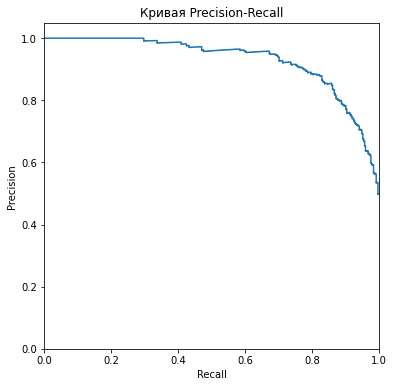

In [25]:
precision, recall, thresholds = precision_recall_curve(target_spacy_test, probabilities_one)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

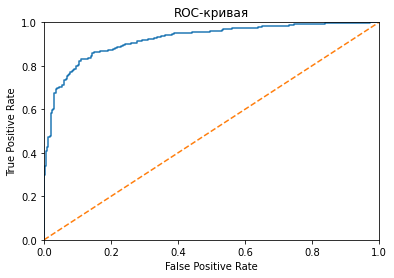

In [26]:
fpr, tpr, thresholds = roc_curve(target_spacy_test, probabilities_one) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [27]:
auc_roc = roc_auc_score(target_spacy_test, probabilities_one) 
print('Оценка в численном виде:', auc_roc)

Оценка в численном виде: 0.9228380675586751


### Примечание:
А до балансировки классов (с class_weight='balanced') было: 0.8056120965396918

In [28]:
print('Воочию посмотрим как совпадают с истиной результаты предсказаний:')
tst = pd.DataFrame()
tst['txt'] = spacy_text_test
tst['toxic'] = np.array(target_spacy_test)
tst['pred'] = pred_spacy
display(tst.head(10))
print('А теперь только токсичные:')
display(tst.query('toxic==1').head())

Воочию посмотрим как совпадают с истиной результаты предсказаний:


,txt,toxic,pred
459,MuZemike also MuZemike be a dirty little faggo...,1,1
1667,hey why the fuck do you have your talk page se...,1,1
92,please take your request for assistance in edi...,0,0
277,Cleanup POV I clean up the article a little bi...,0,0
2770,again not half jokingly how do I remove the pi...,1,1
2006,y u remuv my post AGANE EY you NIGGUR I say I ...,1,0
1720,no source no evidence this be anything save Or...,0,0
831,Dingley just to put you in the picture Trident...,1,1
1721,hi Phill the Shill oh and you know what you ca...,1,1
1554,Feydey be a complete fucking fag I see that he...,1,1


А теперь только токсичные:


,txt,toxic,pred
459,MuZemike also MuZemike be a dirty little faggo...,1,1
1667,hey why the fuck do you have your talk page se...,1,1
2770,again not half jokingly how do I remove the pi...,1,1
2006,y u remuv my post AGANE EY you NIGGUR I say I ...,1,0
831,Dingley just to put you in the picture Trident...,1,1


### Выводы:
1. Осталась довольно большая доля ложно-отрицательных (FN) предсказаний. Часть токсичных комментариев не будет распознана.

### Теперь сделаем обзор по всем остальным вариантам представления текста

In [29]:
%%time

params = {'max_iter': [50, 100, 200],
          'penalty': ['none', 'l2', 'l1', 'elasticnet'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'class_weight': [None, 'balanced'], 
          'C': [1, 10]}

lr = LogisticRegression(multi_class='auto', random_state=RS)
lr_model = GridSearchCV(lr, params, scoring='f1', cv=5)
lr_model.fit(features_spacy_train, target_spacy_train)

print("Лучшие параметры для модели LogisticRegression определенные GridSearchCV:", lr_model.best_params_)

Лучшие параметры для модели LogisticRegression определенные GridSearchCV: {'C': 10, 'class_weight': None, 'max_iter': 50, 'penalty': 'l2', 'solver': 'saga'}
CPU times: user 59.3 s, sys: 367 ms, total: 59.7 s
Wall time: 59.7 s


In [30]:
%time

# пройдемся по всем типам текстов

text_type = ['clear', 'nltk', 'spacy']
res = []

for iii in range(len(text_type)):
    exam_clmn = '{}_text'.format(text_type[iii])
    print('Исследуем модель LogisticRegression на значениях столбца:', exam_clmn)
    exam_text = df_comm[exam_clmn].values.astype('U')
    target = df_comm['toxic']

    text_train, text_test, target_train, target_test = train_test_split(exam_text, target, test_size=TS, random_state=RS)

    features_train = count_tf_idf.fit_transform(text_train) 
    features_test = count_tf_idf.transform(text_test) 
    
    model_exam = LogisticRegression(multi_class='auto', solver='saga', penalty='l2', max_iter=50, class_weight=None, random_state=RS, C=10) #т.к. классы несбалансированы
    model_exam.fit(features_train, target_train)
    print('-- модель обучена')
    
    pred = model_exam.predict(features_test)
    print('-- есть предсказания')
    
    acc = np.round(accuracy_score(target_test, pred), 4)
    f1 = np.round(f1_score(target_test, pred), 4)
    print('-- accuracy_score:', acc)
    print('-- f1_score:', f1)
    res.append({'Тип текста': text_type[iii], 
                'accuracy_score': acc,
                'f1_score': f1}) 
    print('')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Исследуем модель LogisticRegression на значениях столбца: clear_text
-- модель обучена
-- есть предсказания
-- accuracy_score: 0.8377
-- f1_score: 0.8342

Исследуем модель LogisticRegression на значениях столбца: nltk_text
-- модель обучена
-- есть предсказания
-- accuracy_score: 0.839
-- f1_score: 0.8367

Исследуем модель LogisticRegression на значениях столбца: spacy_text
-- модель обучена
-- есть предсказания
-- accuracy_score: 0.8586
-- f1_score: 0.8568



In [31]:
res = pd.DataFrame(res)
display(res)

,Тип текста,accuracy_score,f1_score
0,clear,0.8377,0.8342
1,nltk,0.8390,0.8367
2,spacy,0.8586,0.8568


### Выводы:
1. <s>NLTK дал самый лучший результат.</s> Результат нестабилен - в этот раз лучший результат у spacy.
2. Лемматизация дает незначительный прирост качества модели по сравнению с очищенным текстом.

## Обучение
### Вариант с BERT

In [32]:
%time

print('Сначала наугад протестируем модель CatBoostClassifier (параметры отличаются от тех, что будут использованы далее):')

model_cb = CatBoostClassifier(bootstrap_type='MVS', depth=4, grow_policy='Depthwise', iterations=100, learning_rate=0.03, silent=True, random_seed=RS)
model_cb.fit(bert_features_train, bert_target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Сначала наугад протестируем модель CatBoostClassifier (параметры отличаются от тех, что будут использованы далее):


In [33]:
%time

pred_cb = model_cb.predict(bert_features_test)
print('cross_val_score:', cross_val_score(model_cb, bert_features_test, bert_target_test, cv=3))
print('accuracy_score:', accuracy_score(bert_target_test, pred_cb))
print('f1_score:', f1_score(bert_target_test, pred_cb))
print(model_cb.get_params(deep=False))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 98.9 µs
cross_val_score: [0.824 0.84  0.848]
accuracy_score: 0.856
f1_score: 0.864321608040201
{'iterations': 100, 'learning_rate': 0.03, 'depth': 4, 'random_seed': 12345, 'silent': True, 'bootstrap_type': 'MVS', 'grow_policy': 'Depthwise'}


<div class="alert alert-info"> <b>Комментарий студента:</b> В предыдущий раз (с RuBERT) было:
<li> cross_val_score: [0.756 0.784 0.752]
<li> accuracy_score: 0.76
<li> f1_score: 0.7721518987341771
<div> <b>Результат значительно улучшился! F1=0.864321608040201</b></div>
</div>    

In [34]:
%%time

params = {'max_depth': [4, 8, 10],
          'n_estimators': range(80, 240, 40),
         'min_samples_leaf': [1, 2]}

rf = RandomForestClassifier(class_weight=None, random_state=RS)
rf_model = GridSearchCV(rf, params, scoring='f1', cv=3)
rf_model.fit(bert_features_train, bert_target_train)

print("Лучшие параметры для модели RandomForestClassifier определенные GridSearchCV:", rf_model.best_params_)

Лучшие параметры для модели RandomForestClassifier определенные GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
CPU times: user 3min 11s, sys: 937 ms, total: 3min 12s
Wall time: 3min 13s


In [35]:
%%time

models = [LogisticRegression(multi_class='auto', solver='saga', penalty='l2', max_iter=50, class_weight=None, random_state=RS, C=10),          
          DecisionTreeClassifier(class_weight=None, max_depth=8, random_state=RS),
          RandomForestClassifier(class_weight=None, n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=RS),
          CatBoostClassifier(bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=200, learning_rate=0.15, silent=True, random_seed=RS),
          LGBMClassifier(),
          XGBClassifier(),
          DummyClassifier(strategy='prior', random_state=RS)]

bert_results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(bert_features_train, bert_target_train)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    bert_pred = md.predict(bert_features_test)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    
    md_acc = np.round(accuracy_score(bert_target_test, bert_pred), 4)
    md_f1 = np.round(f1_score(bert_target_test, bert_pred), 4)
    
    print('-- accuracy_score:', md_acc)
    print('-- f1_score:', md_f1)
    bert_results.append({'Модель': md.__class__.__name__, 
                         'accuracy_score': md_acc,
                         'f1_score': md_f1,
                         'Время_обучения': dt1,
                         'Время_предсказания': dt2,                    
                         'Гиперпараметры': md.get_params(deep=False),
                         'Модель_пригодна': md_f1>=CRIT_F1,
                         'pred': bert_pred}) 
    print('')
              
bert_results = pd.DataFrame(bert_results)
display(bert_results.drop('pred', axis=1))

Идут вычисления по модели LogisticRegression: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 12345, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- accuracy_score: 0.8707
-- f1_score: 0.8771

Идут вычисления по модели DecisionTreeClassifier: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}
-- модель обучена
-- получены предсказания
-- accuracy_score: 0.7867
-- f1_score: 0.799

Идут вычисления по модели RandomForestClassifier: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1

,Модель,accuracy_score,f1_score,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LogisticRegression,0.8707,0.8771,1.04s,0.01s,"{'C': 10, 'class_weight': None, 'dual': False,...",True
1,DecisionTreeClassifier,0.7867,0.7990,1.44s,0.0s,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",True
2,RandomForestClassifier,0.8427,0.8518,6.81s,0.06s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",True
3,CatBoostClassifier,0.8733,0.8814,145.04s,0.02s,"{'iterations': 200, 'learning_rate': 0.15, 'de...",True
4,LGBMClassifier,0.8480,0.8579,393.2s,0.02s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
5,XGBClassifier,0.8613,0.8690,132.31s,0.19s,"{'objective': 'binary:logistic', 'use_label_en...",True
6,DummyClassifier,0.5293,0.6922,0.0s,0.0s,"{'constant': None, 'random_state': 12345, 'str...",False


CPU times: user 11min 10s, sys: 5.38 s, total: 11min 16s
Wall time: 11min 20s


In [36]:
bert_best_mod = bert_results.sort_values(by = 'f1_score', ascending = False).reset_index(drop=True).head(1)
print('Лучшая модель (при работе с BERT):', bert_best_mod.loc[0, 'Модель'])

Лучшая модель (при работе с BERT): CatBoostClassifier


### Вариант без BERT (на данных NLTK+TF-IDF)

In [37]:
%time

nltk_text = df_comm['nltk_text'].values.astype('U')
nltk_target = df_comm['toxic']

nltk_text_train, nltk_text_test, nltk_target_train, nltk_target_test = train_test_split(nltk_text, nltk_target, test_size=TS, random_state=RS)

count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
nltk_features_train = count_tf_idf.fit_transform(nltk_text_train) 
nltk_features_test = count_tf_idf.transform(nltk_text_test) 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [38]:
%%time

models = [LogisticRegression(multi_class='auto', solver='saga', penalty='l2', max_iter=50, class_weight=None, random_state=RS, C=10),          
          DecisionTreeClassifier(class_weight=None, max_depth=8, random_state=RS),
          RandomForestClassifier(class_weight=None, n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=RS),
          CatBoostClassifier(bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=200, learning_rate=0.15, silent=True, random_seed=RS),
          LGBMClassifier(),
          XGBClassifier(),
          DummyClassifier(strategy='prior', random_state=RS)]

tf_idf_results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(nltk_features_train, nltk_target_train)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    nltk_pred = md.predict(nltk_features_test)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    
    md_acc = np.round(accuracy_score(nltk_target_test, nltk_pred), 4)
    md_f1 = np.round(f1_score(nltk_target_test, nltk_pred), 4)
    
    print('-- accuracy_score:', md_acc)
    print('-- f1_score:', md_f1)
    tf_idf_results.append({'Модель': md.__class__.__name__, 
                           'accuracy_score': md_acc,
                           'f1_score': md_f1,
                           'Время_обучения': dt1,
                           'Время_предсказания': dt2,                    
                           'Гиперпараметры': md.get_params(deep=False),
                           'Модель_пригодна': md_f1>=CRIT_F1,
                           'pred': nltk_pred}) 
    print('')
              
tf_idf_results = pd.DataFrame(tf_idf_results)
display(tf_idf_results.drop('pred', axis=1))

Идут вычисления по модели LogisticRegression: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 12345, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- accuracy_score: 0.839
-- f1_score: 0.8367

Идут вычисления по модели DecisionTreeClassifier: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}
-- модель обучена
-- получены предсказания
-- accuracy_score: 0.6466
-- f1_score: 0.7115

Идут вычисления по модели RandomForestClassifier: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1

,Модель,accuracy_score,f1_score,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LogisticRegression,0.8390,0.8367,0.05s,0.0s,"{'C': 10, 'class_weight': None, 'dual': False,...",True
1,DecisionTreeClassifier,0.6466,0.7115,0.05s,0.0s,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",False
2,RandomForestClassifier,0.6963,0.7542,0.41s,0.04s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",True
3,CatBoostClassifier,0.8233,0.8085,49.71s,0.02s,"{'iterations': 200, 'learning_rate': 0.15, 'de...",True
4,LGBMClassifier,0.7984,0.7974,141.76s,0.01s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
5,XGBClassifier,0.8024,0.7989,52.54s,0.08s,"{'objective': 'binary:logistic', 'use_label_en...",True
6,DummyClassifier,0.4921,0.6596,0.0s,0.0s,"{'constant': None, 'random_state': 12345, 'str...",False


CPU times: user 4min 1s, sys: 1.81 s, total: 4min 2s
Wall time: 4min 4s


In [39]:
tf_idf_best_mod = tf_idf_results.sort_values(by = 'f1_score', ascending = False).reset_index(drop=True).head(1)
print('Лучшая модель (при работе с TF-IDF):', tf_idf_best_mod.loc[0, 'Модель'])

Лучшая модель (при работе с TF-IDF): LogisticRegression


In [40]:
print('Сравним результаты BERT и TF-IDF:')
delta = tf_idf_results.drop(['pred', 'Модель_пригодна', 'Гиперпараметры', 'Время_предсказания', 'Время_обучения', 'accuracy_score'], axis=1)
delta = delta.rename(columns={"f1_score": "f1_score_NLTK_TF_IDF"})
delta['f1_score_BERT'] = bert_results['f1_score']
display(delta)

Сравним результаты BERT и TF-IDF:


,Модель,f1_score_NLTK_TF_IDF,f1_score_BERT
0,LogisticRegression,0.8367,0.8771
1,DecisionTreeClassifier,0.7115,0.7990
2,RandomForestClassifier,0.7542,0.8518
3,CatBoostClassifier,0.8085,0.8814
4,LGBMClassifier,0.7974,0.8579
5,XGBClassifier,0.7989,0.8690
6,DummyClassifier,0.6596,0.6922


## Выводы
1. Балансировка классов оказала решающее действие на качество модели - метрика f1 подросла примерно в 2 раза.
2. <s>При заданных параметрах метод TF-IDF дает признаки для предсказания немного лучше чем в результате работы BERT. Возможно, дело в том, что для BERT используется ограничение длинны MXL=50.</s>После применения DistilBert метрика F1 стала чуть лучше (0.88 против 0.85) чем для метода TF-IDF, но скорость работы последнего выше.
3. <s>Модель CatBoostClassifier на обоих типах признаков дала примерно одинаковые значения</s>Модель CatBoostClassifier дала лучшее значение на данных подготвленных BERT (F1=0.8814), а модель LogisticRegression на признаках подгтовленных spacy+TF-IDF дала самый лучший результат (F1=0.8556 на данных подготовленных spacy и 0.8367 на данных подгоовленных NLTK).